# FRA 503: Deep Reinforcement Learning
# Homework 1

## Part 1: Setting up Multi-armed Bandit.

In [53]:
import numpy as np
import matplotlib.pyplot as plt

#### Bandit Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - hidden reward distributions สำหรับแต่ละ bandit (0-1 แทนโอกาสได้รางวัล 0-100%) 
2.  ฟังชั่น get_reward 
    - รับ bandit_index เพื่อระบุ Bandit ที่ถูกเลือก
    - สุ่มค่าโดยอิงตาม rate ที่กำหนดใน hidden reward distributions ถ้าถูกรางวัลจะ return 1 ไม่ถูกจะ return 0

In [52]:
import numpy as np

class Bandit:
    def __init__(self, n_bandits):
        #จำนวน Bandits
        self.n_bandits = n_bandits
        # สร้าง hidden reward distributions สำหรับแต่ละ bandit (สุ่มค่าความน่าจะเป็นระหว่าง 0 ถึง 1)
        # self.reward_distributions = np.random.uniform(0, 1, n_bandits)
        self.reward_distributions = [0.1 , 0.2 , 0.15, 0.5, 0.3]

    def get_reward(self, bandit_index):
        if 0 <= bandit_index < self.n_bandits:
            # สุ่มรางวัล: 1 (ถูกรางวัล) หรือ 0 (ไม่ถูกรางวัล) ตามความน่าจะเป็น
            return 1 if np.random.rand() < self.reward_distributions[bandit_index] else 0
        else:
            raise ValueError("Bandit index out of range!")



#### Agent Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - Learning Rate
    - Q-value
    - ค่าคงที่สำหรับ UCB
    - จำนวน timestep ทั้งหมด
    - action_probs ความน่าจะเป็นในการเลือกครั้งแรกจะเท่ากันทุก  bandit


2. ฟังชั่น select_action ใช้ในการเลือก bandits โดยตั้งต้นจะให้ใช้ UCB 
    - Upper Confidence Bound (UCB)
        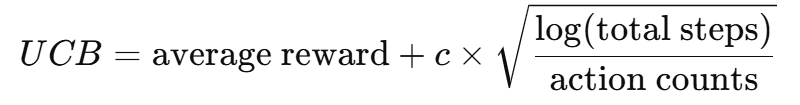


3. ฟังชั่น update




In [60]:
class Agent:
    def __init__(self, n_bandits ,c =2 , epsilon = 0.5):
        #จำนวน bandits
        self.n_bandits = n_bandits 
        # เริ่มต้นค่าประมาณการรางวัล (Q-value) และ policy (action distribution)
        self.q_values = np.zeros(n_bandits) 
        
        #Upper Confidence Bound (UCB)
        self.c = c  # ค่าคงที่สำหรับ UCB  
        self.total_steps = 0  # จำนวน timestep ทั้งหมด
        self.action_counts = np.zeros(n_bandits)  # จำนวนครั้งที่เลือกแต่ละ Bandit
        
        #Epsilon-Greedy
        self.epsilon = epsilon  # ค่า Epsilon สำหรับ Epsilon-Greedy
    
    def select_action_UCB(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Upper Confidence Bound (UCB)
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1
        ucb_values = np.zeros(self.n_bandits)
        
        for i in range(self.n_bandits):
            if self.action_counts[i] > 0:
                # ปรับสูตรความมั่นใจ (เพิ่ม +1 ในตัวหารเพื่อป้องกันหารด้วย 0)
                confidence = self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[i] + 1))
                ucb_values[i] = self.q_values[i] + confidence
            else:
                # เลือก Bandit ที่ยังไม่เคยถูกเลือก
                return i
        
        # เลือก Bandit ที่มีค่า UCB สูงสุด
        return np.argmax(ucb_values)
    
    def select_action_epsilon_greedy(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Epsilon-Greedy
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1

        if np.random.rand() < self.epsilon:
            # Exploration: เลือก Bandit แบบสุ่ม
            return np.random.randint(0, self.n_bandits)
        else:
            # Exploitation: เลือก Bandit ที่มีค่า Q-value สูงสุด
            return np.argmax(self.q_values)
        
    
    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        :param action: ดัชนีของ Bandit ที่เลือก
        :param reward: รางวัลที่ได้รับจาก Bandit นั้น
        """
        self.action_counts[action] += 1
        # อัปเดต Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

In [61]:
def run_experiment(n_bandits, n_steps, c=2, epsilon=0.5, method="UCB"):
    bandit = Bandit(n_bandits)
    agent = Agent(n_bandits, c, epsilon)

    rewards = []
    cumulative_rewards = []

    for step in range(n_steps):
        # เลือกฟังก์ชันการเลือก Bandit ตาม method ที่กำหนด
        if method == "UCB":
            action = agent.select_action_UCB()
        elif method == "Epsilon-Greedy":
            action = agent.select_action_epsilon_greedy()
        else:
            raise ValueError("Invalid method. Choose 'UCB' or 'Epsilon-Greedy'.")

        # รับรางวัลจาก Bandit
        reward = bandit.get_reward(action)

        # อัปเดต Q-value และจำนวนครั้งที่เลือก
        agent.update(action, reward)

        # เก็บรางวัลและคำนวณรางวัลสะสมเฉลี่ย
        rewards.append(reward)
        cumulative_rewards.append(np.mean(rewards))

    return rewards, cumulative_rewards, bandit.reward_distributions


Hidden reward distributions: [0.45917821 0.44191363 0.83836071 0.81930831 0.73814503]
Average reward after 1000 steps using UCB: 0.75


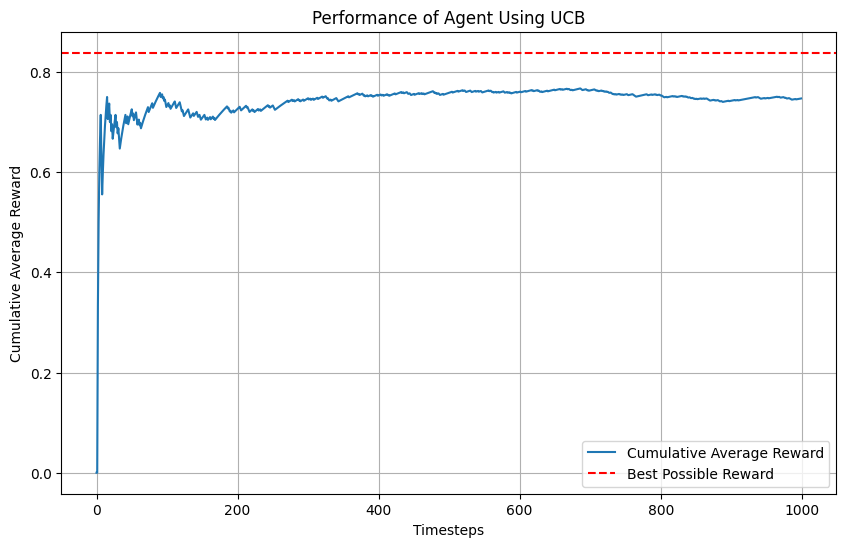

In [68]:
if __name__ == "__main__":
    n_bandits = 5     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 2             # ค่า UCB ค่าคงที่สำหรับ Exploration
    epsilon = 0.1     # ค่า Epsilon สำหรับ Epsilon-Greedy

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(
        n_bandits=n_bandits,
        n_steps=n_steps,
        c=c,
        epsilon=epsilon,
        method=method
    )

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


## Part 3: Implementing UCB

In [ ]:
if __name__ == "__main__":
    n_bandits = 5     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 2             # ค่า UCB ค่าคงที่สำหรับ Exploration

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(n_bandits=n_bandits,n_steps=n_steps,c=c,epsilon=epsilon,method=method)

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


## Part 2: Implementing epsilon-greedy algorithm.

Hidden reward distributions: [0.03894406 0.95360461 0.95963654 0.62050933 0.02321802]
Average reward after 1000 steps using Epsilon-Greedy: 0.75


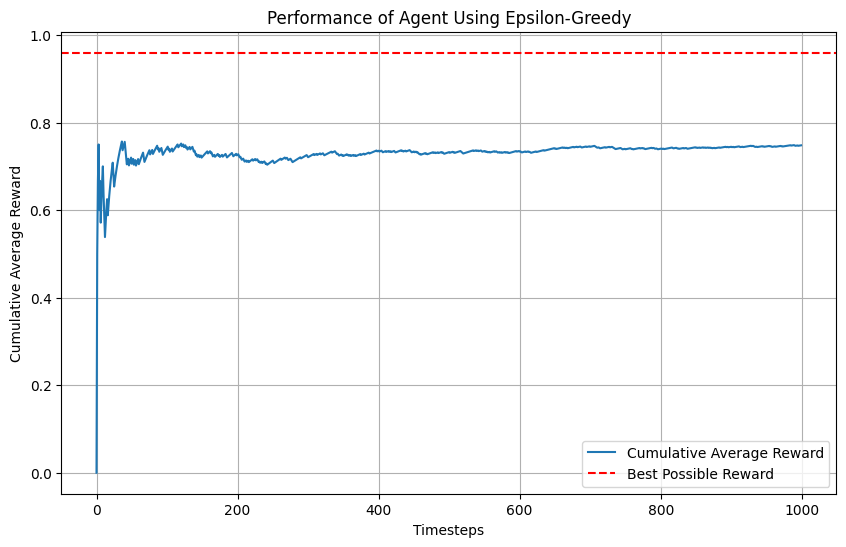

In [75]:
if __name__ == "__main__":
    n_bandits = 5     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    epsilon = 0.5     # ค่า Epsilon สำหรับ Epsilon-Greedy

    # เลือกวิธีการทดลอง
    method = "Epsilon-Greedy"  

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(n_bandits=n_bandits,n_steps=n_steps,c=c,epsilon=epsilon,method=method)

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()
